In [1]:
import numpy as np
import pandas as pd

import seaborn as sns  
sns.set_style("darkgrid")
import matplotlib.pyplot as plt
import matplotlib as mpl
sns.set(font_scale=1.5)
mpl.rcParams["font.sans-serif"]=["SimHei"]#展示中文字体
mpl.rcParams["axes.unicode_minus"]=False#处理负刻度值

In [2]:
data_raw = pd.read_excel("data/附件1-商家历史出货量表.xlsx")

In [3]:
data = data_raw
data.head()

,seller_no,product_no,warehouse_no,date,qty
0,seller_19,product_448,wh_30,2023-05-09,10
1,seller_19,product_448,wh_30,2023-04-17,14
2,seller_19,product_448,wh_30,2023-01-09,2
3,seller_19,product_448,wh_30,2023-01-20,1
4,seller_19,product_448,wh_30,2023-02-13,22


- 数据中无空缺数据

# 时间序列变化观察

In [4]:
product = data[["product_no","date","qty"]].groupby(["product_no","date"]).mean()
product_5 = product.groupby(level=1).head(5)
product_5

qty
product_no   date                 
product_1001 2022-12-01  13.333333
             2022-12-02  11.000000
             2022-12-03  11.666667
             2022-12-04   9.666667
             2022-12-05   8.000000
...                            ...
product_1007 2023-05-11   2.000000
             2023-05-12   1.500000
             2023-05-13   2.000000
             2023-05-14   4.500000
             2023-05-15   4.000000

[830 rows x 1 columns]

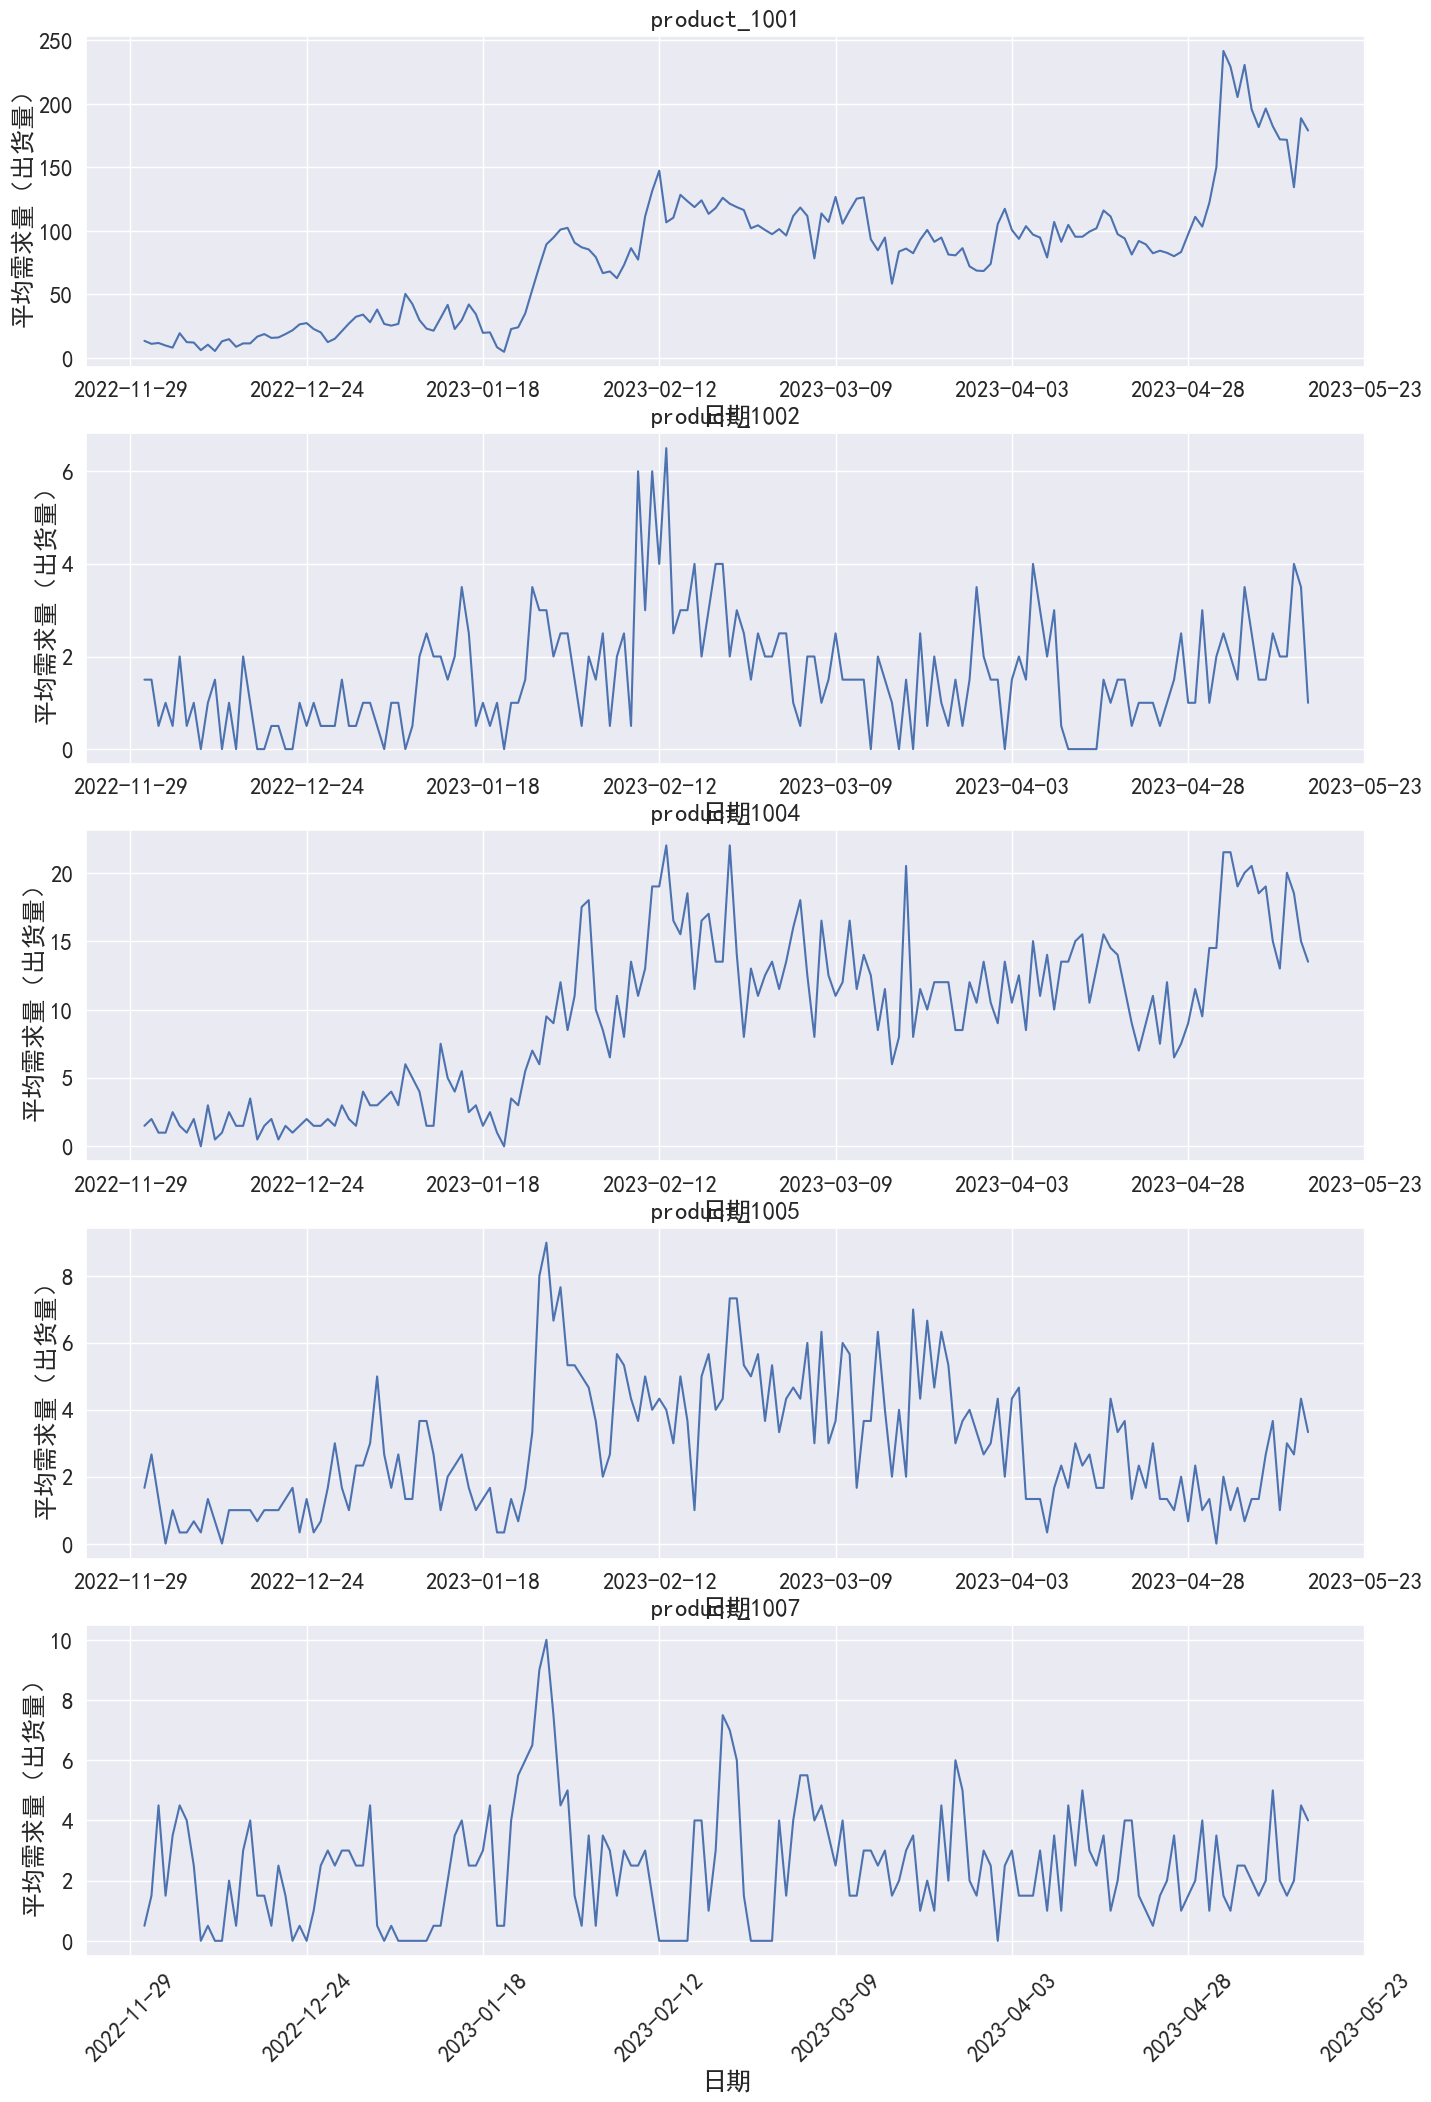

In [5]:
fig, ax = plt.subplots(5,1)

i = 0
for ind, df in product_5.groupby(level=0):
    ax[i].xaxis_date()
    
    index = pd.to_datetime(df.index.get_level_values(1))
    ax[i].plot(index, df["qty"])
    #ax.plot(df.index, df["qty"])
    
    # 设置x轴标签为日期格式
    ax[i].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
    ax[i].xaxis.set_major_locator(plt.MaxNLocator(nbins=9))
    ax[i].set_title(ind)
    
    ax[i].set_ylabel('平均需求量（出货量）')
    ax[i].set_xlabel('日期')
    
    i+=1

# 设置x轴标签旋转45度，使其更好地显示
plt.xticks(rotation=45)

plt.subplots_adjust(left=0, right=2, bottom = 0, top= 4)
plt.show()

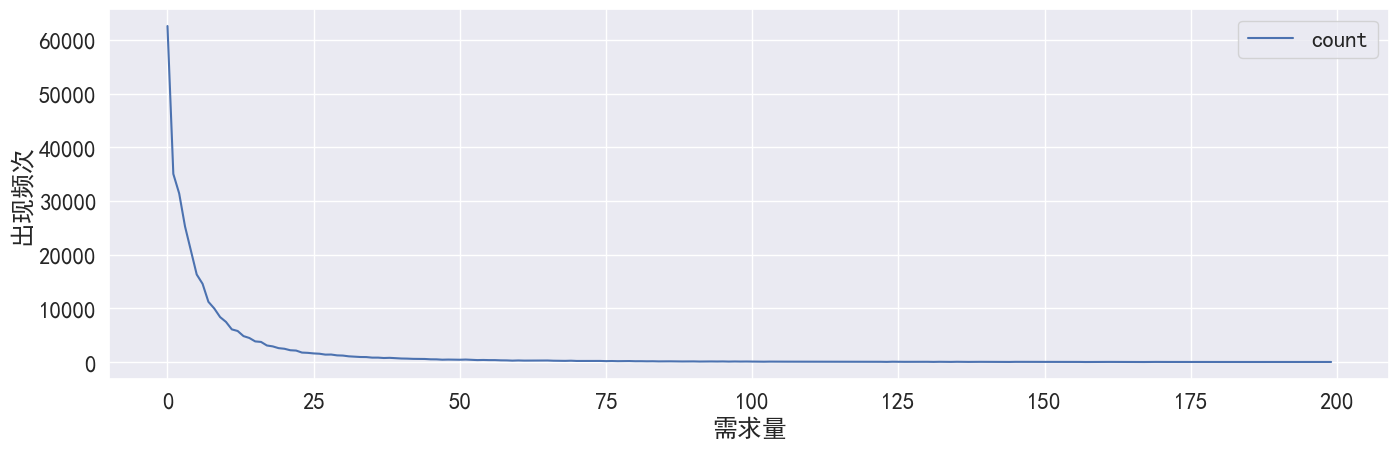

In [7]:
count = data[["product_no","qty"]].groupby("qty").count()
count.columns = ["count"]
count[:200].plot()
plt.xlabel("需求量")
plt.ylabel("出现频次")
plt.subplots_adjust(left=0, right=2)

## 平稳性

- 均值（即从t=0到当前时间步的均值）为常数
- 方差收敛
- 协方差仅与时间间隔有关，与位置无关。

> https://zhuanlan.zhihu.com/p/393594761

### ACF 指自相关性系数 $ r_k $

In [50]:
from statsmodels.tsa.stattools import acf

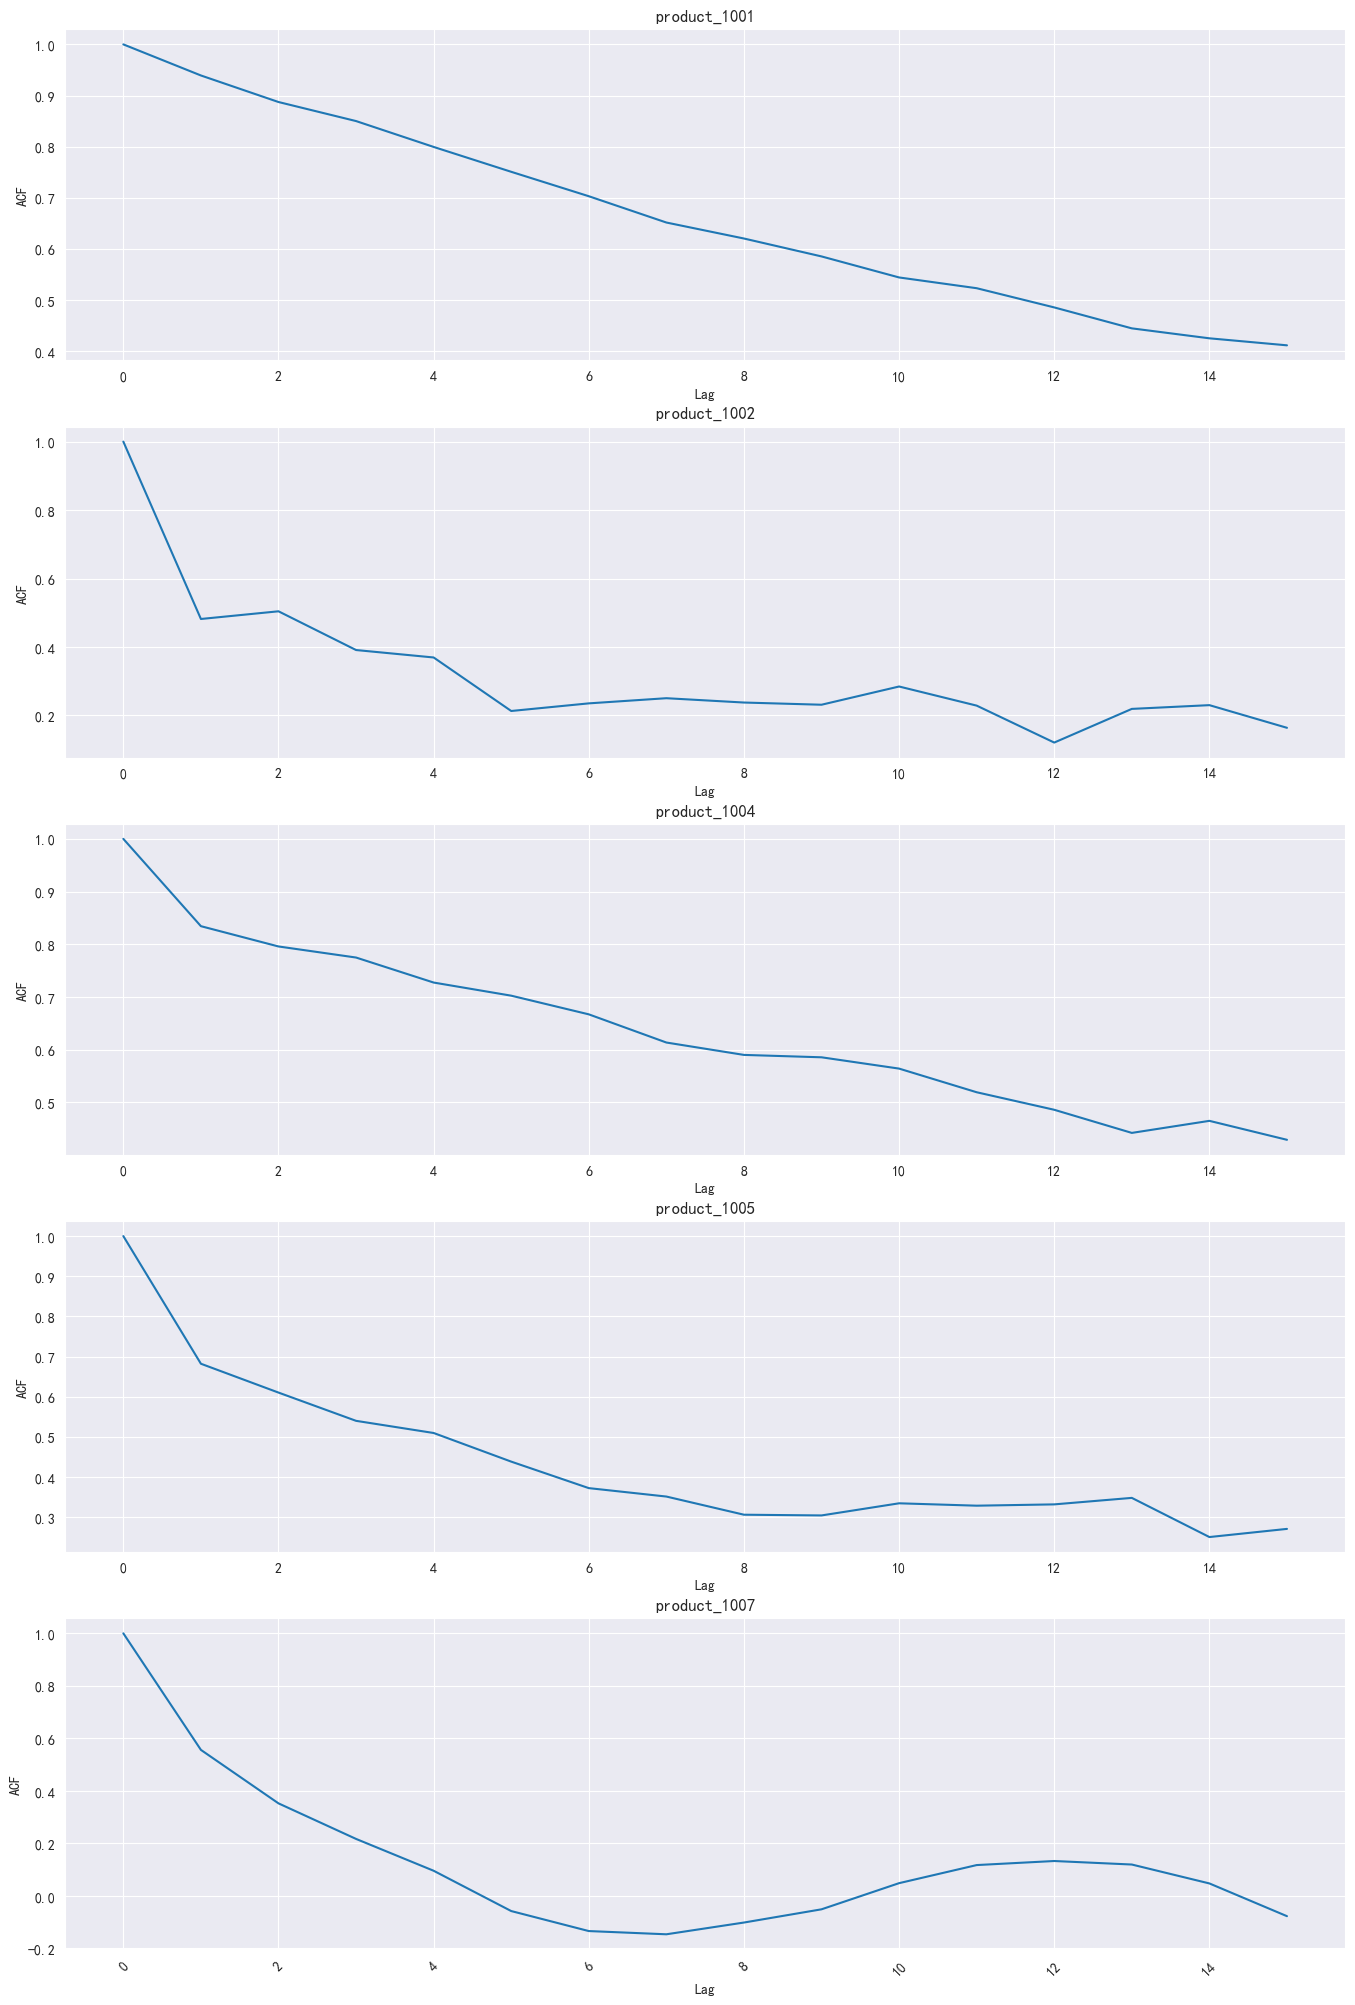

In [61]:
# 计算时间序列数据的ACF
lags = 15  # 滞后阶数

fig, ax = plt.subplots(5,1)

i = 0
for ind, df in product_5.groupby(level=0):
    
    acf_values = acf(df["qty"], nlags=lags)
    
    ax[i].plot([i for i in range(lags+1)], acf_values)
    #ax.plot(df.index, df["qty"])

    ax[i].set_title(ind)
    
    ax[i].set_ylabel('ACF')
    ax[i].set_xlabel('Lag')
    
    i+=1

# 设置x轴标签旋转45度，使其更好地显示
plt.xticks(rotation=45)

plt.subplots_adjust(left=0, right=2, bottom = 0, top= 4)
plt.show()

- 可以看出时间序列是弱平稳的

### Augmented Dickey-Fuller检验

D:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
D:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
D:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
D:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is great

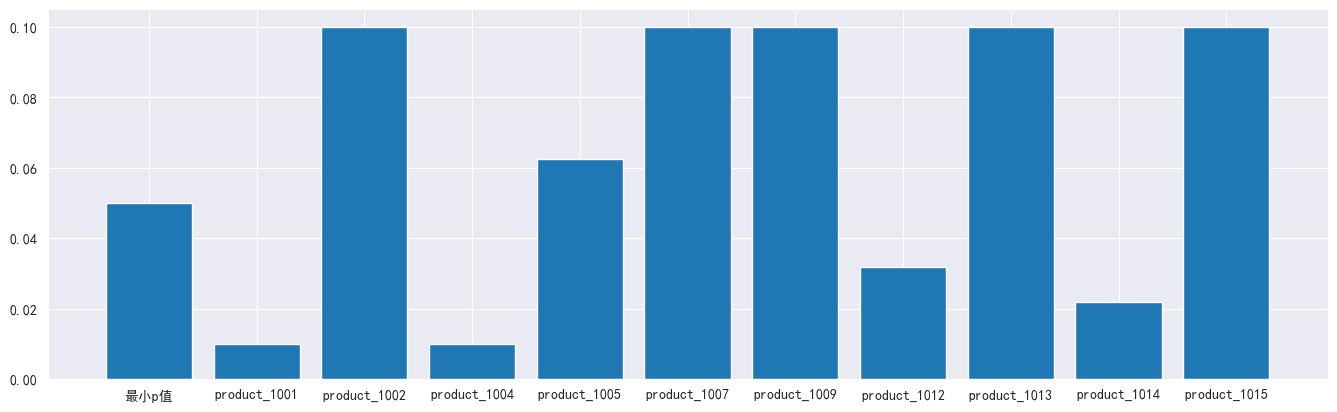

In [72]:
from statsmodels.tsa.stattools import adfuller

p_values = {"最小p值":0.05}

for ind, df in product.groupby(level=1).head(10).groupby(level=0):
    
    result = kpss(df["qty"])
    p_values[ind] = result[1]

plt.bar(p_values.keys(), p_values.values())
plt.subplots_adjust(left=0, right=2)

- 部分平稳部分不平稳
    - 继续分析商品类型和平稳性的关系

In [73]:
product_type_raw = pd.read_excel("data/附件2-商品信息表.xlsx")
product_type_raw.head()

,product_no,category1,category2,category3
0,product_1412,家装建材,厨房卫浴,厨房卫浴_1
1,product_1383,家装建材,电工电料,电工电料_1
2,product_1323,家装建材,电工电料,电工电料_1
3,product_1345,家装建材,电工电料,电工电料_1
4,product_1325,家装建材,电工电料,电工电料_1


In [74]:
product_type = product_type_raw.set_index("product_no")
product_type

,category1,category2,category3
product_no,,,
product_1412,家装建材,厨房卫浴,厨房卫浴_1
product_1383,家装建材,电工电料,电工电料_1
product_1323,家装建材,电工电料,电工电料_1
product_1345,家装建材,电工电料,电工电料_1
product_1325,家装建材,电工电料,电工电料_1
...,...,...,...
product_576,家用电器,个护健康,个护健康_15
product_98,手机通讯,手机配件,手机配件_6
product_1902,电脑、办公,外设产品,外设产品_2


In [113]:
from statsmodels.tsa.stattools import adfuller

stabl = [ adfuller(df["qty"])[1]<0.05 for ind, df in product.groupby(level=0) ]

product_stable = pd.DataFrame({"平稳性":stabl})
product_stable.index = product.index.get_level_values(0).unique()
    

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


D:\ProgramData\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:940: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


In [114]:
product_stable

,平稳性
product_no,
product_1001,False
product_1002,False
product_1004,False
product_1005,True
product_1007,True
...,...
product_988,True
product_993,True
product_994,True


In [115]:
product_stable["类型"]=product_type["category1"].loc[product_stable.index]

product_stable

,平稳性,类型
product_no,,
product_1001,False,数码
product_1002,False,数码
product_1004,False,数码
product_1005,True,数码
product_1007,True,数码
...,...,...
product_988,True,数码
product_993,True,数码
product_994,True,数码


In [116]:
product_stable.groupby("类型").mean()

,平稳性
类型,
个人护理,0.649351
传统滋补,0.000000
厨具,0.674699
宠物生活,0.701031
家具,0.916667
家庭清洁/纸品,0.800000
家用电器,0.515152
家装建材,0.697115
手机通讯,0.723577


- 平稳性堪忧，需要一定的解释